### Cab-Driver Agent

In [25]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [26]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [27]:
print(type(Time_matrix))
print(Time_matrix.max())
print(Time_matrix.min())
print(Time_matrix.mean())
print(Time_matrix.var())

<class 'numpy.ndarray'>
11.0
0.0
3.0542857142857143
7.93705306122449


In [28]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [29]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01
        self.epsilon = 1
        self.epsilon_max = 1
        self.epsilon_decay = -0.0005 #for 15k
        #self.epsilon_decay = -0.00015 #for 20k
        self.epsilon_min = 0.00001
        
        self.batch_size = 32

        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # Initialize the value of the states tracked
        self.states_tracked = []
        
        # We are going to track state [0,0,0] and action (0,2) at index 2 in the action space.
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        """
        Function that takes in the agent and constructs the network
        to train it
        @return model
        @params agent
        """
        input_shape = self.state_size
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model

    def get_action(self, state, possible_actions_index, actions):
        """
        get action in a state according to an epsilon-greedy approach
        possible_actions_index, actions are the 'ride requests' that teh driver got.
        """        
        # get action from model using epsilon-greedy policy
        # Decay in ε after each episode       
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from the ride requests
            return random.choice(possible_actions_index)
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)

            # Use the model to predict the Q_values.
            q_value = self.model.predict(state)

            # truncate the array to only those actions that are part of the ride  requests.
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]

            return possible_actions_index[np.argmax(q_vals_possible)]

    def append_sample(self, state, action_index, reward, next_state, done):
        """appends the new agent run output to replay buffer"""
        self.memory.append((state, action_index, reward, next_state, done))
        
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        """ 
        Function to train the model on eacg step run.
        Picks the random memory events according to batch size and 
        runs it through the network to train it.
        """
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            # initialise two matrices - update_input and update_output
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []

            # populate update_input and update_output and the lists rewards, actions, done
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)

            # predict the target q-values from states s
            target = self.model.predict(update_input)
            # target for q-network
            target_qval = self.model.predict(update_output)


            # update the target values
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            # model fit
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            
    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked.append(q_value[0][2])
        
    def save_test_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_test.append(q_value[0][2])

    def save(self, name):
        with open(name, 'wb') as file:  
            pickle.dump(self.model, file,pickle.HIGHEST_PROTOCOL)

### DQN block

In [30]:
episode_time = 24*30 #30 days before which car has to be recharged
n_episodes = 15000
m = 5
t = 24
d = 7

# Invoke Env class
env = CabDriver()
action_space, state_space, state = env.reset()

# Set up state and action sizes.
state_size = m+t+d
action_size = len(action_space)

# Invoke agent class
agent = DQNAgent(action_size=action_size, state_size=state_size)

# to store rewards in each episode
rewards_per_episode, episodes = [], []
# Rewards for state [0,0,0] being tracked.
rewards_init_state = []

In [31]:
start_time = time.time()
score_tracked = []

for episode in range(n_episodes):

    done = False
    score = 0
    track_reward = False

    # reset at the start of each episode
    env = CabDriver()
    action_space, state_space, state = env.reset()
    # Save the initial state so that reward can be tracked if initial state is [0,0,0]
    initial_state = env.state_init


    total_time = 0  # Total time driver rode in this episode
    while not done:
        # 1. Get a list of the ride requests driver got.
        possible_actions_indices, actions = env.requests(state)
        # 2. Pick epsilon-greedy action from possible actions for the current state.
        action = agent.get_action(state, possible_actions_indices, actions)

        # 3. Evaluate your reward and next state
        reward, next_state, step_time = env.step(state, env.action_space[action], Time_matrix)
        # 4. Total time driver rode in this episode
        total_time += step_time
        if (total_time > episode_time):
            # if ride does not complete in stipu;ated time skip
            # it and move to next episode.
            done = True
        else:
            # 5. Append the experience to the memory
            agent.append_sample(state, action, reward, next_state, done)
            # 6. Train the model by calling function agent.train_model
            agent.train_model()
            # 7. Keep a track of rewards, Q-values, loss
            score += reward
            state = next_state

    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)
    

    # epsilon decay
    agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)

    # every 10 episodes:
    if ((episode + 1) % 10 == 0):
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3} total_time {4}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon, total_time))
    # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()

    # Total rewards per episode
    score_tracked.append(score)

    if(episode % 1000 == 0):
        print("Saving Model {}".format(episode))
        agent.save(name="model_weights.pkl")
    
elapsed_time = time.time() - start_time
print(elapsed_time)


Saving Model 0
episode 9, reward -121.0, memory_length 1396, epsilon 0.9955001547284723 total_time 726.0
episode 19, reward -139.0, memory_length 2000, epsilon 0.9905350769930761 total_time 723.0
episode 29, reward 311.0, memory_length 2000, epsilon 0.9855947626861951 total_time 722.0
episode 39, reward -180.0, memory_length 2000, epsilon 0.9806790882997144 total_time 727.0
episode 49, reward 40.0, memory_length 2000, epsilon 0.9757879309415182 total_time 721.0
episode 59, reward -12.0, memory_length 2000, epsilon 0.9709211683324178 total_time 724.0
episode 69, reward 2.0, memory_length 2000, epsilon 0.9660786788030947 total_time 728.0
episode 79, reward -225.0, memory_length 2000, epsilon 0.9612603412910584 total_time 721.0
episode 89, reward -182.0, memory_length 2000, epsilon 0.9564660353376199 total_time 723.0
episode 99, reward -130.0, memory_length 2000, epsilon 0.9516956410848808 total_time 727.0
episode 109, reward -129.0, memory_length 2000, epsilon 0.9469490392727365 total_t

episode 889, reward 433.0, memory_length 2000, epsilon 0.6411383568390387 total_time 721.0
episode 899, reward 478.0, memory_length 2000, epsilon 0.6379406659439346 total_time 725.0
episode 909, reward 352.0, memory_length 2000, epsilon 0.6347589235987051 total_time 722.0
episode 919, reward 433.0, memory_length 2000, epsilon 0.631593050259626 total_time 722.0
episode 929, reward 450.0, memory_length 2000, epsilon 0.6284429667796988 total_time 726.0
episode 939, reward 770.0, memory_length 2000, epsilon 0.6253085944066726 total_time 729.0
episode 949, reward 212.0, memory_length 2000, epsilon 0.6221898547810748 total_time 727.0
episode 959, reward 614.0, memory_length 2000, epsilon 0.6190866699342522 total_time 722.0
episode 969, reward 839.0, memory_length 2000, epsilon 0.6159989622864221 total_time 725.0
episode 979, reward 629.0, memory_length 2000, epsilon 0.6129266546447325 total_time 722.0
episode 989, reward 640.0, memory_length 2000, epsilon 0.6098696702013323 total_time 724.0


episode 1779, reward 743.0, memory_length 2000, epsilon 0.41085702335792745 total_time 722.0
episode 1789, reward 763.0, memory_length 2000, epsilon 0.40880786540509717 total_time 722.0
episode 1799, reward 788.0, memory_length 2000, epsilon 0.4067689276701942 total_time 725.0
episode 1809, reward 716.0, memory_length 2000, epsilon 0.40474015917966877 total_time 723.0
episode 1819, reward 670.0, memory_length 2000, epsilon 0.4027215092142031 total_time 725.0
episode 1829, reward 826.0, memory_length 2000, epsilon 0.4007129273074429 total_time 723.0
episode 1839, reward 843.0, memory_length 2000, epsilon 0.39871436324473586 total_time 723.0
episode 1849, reward 692.0, memory_length 2000, epsilon 0.3967257670618763 total_time 722.0
episode 1859, reward 377.0, memory_length 2000, epsilon 0.3947470890438561 total_time 724.0
episode 1869, reward 990.0, memory_length 2000, epsilon 0.3927782797236218 total_time 730.0
episode 1879, reward 991.0, memory_length 2000, epsilon 0.3908192898808378 t

episode 2669, reward 1429.0, memory_length 2000, epsilon 0.2632871545461373 total_time 724.0
episode 2679, reward 1010.0, memory_length 2000, epsilon 0.261974004384539 total_time 727.0
episode 2689, reward 1144.0, memory_length 2000, epsilon 0.26066740358669477 total_time 724.0
episode 2699, reward 999.0, memory_length 2000, epsilon 0.25936731948751673 total_time 726.0
episode 2709, reward 1164.0, memory_length 2000, epsilon 0.2580737195848345 total_time 722.0
episode 2719, reward 1190.0, memory_length 2000, epsilon 0.25678657153858325 total_time 722.0
episode 2729, reward 1148.0, memory_length 2000, epsilon 0.2555058431699948 total_time 724.0
episode 2739, reward 1204.0, memory_length 2000, epsilon 0.25423150246079323 total_time 724.0
episode 2749, reward 1035.0, memory_length 2000, epsilon 0.2529635175523944 total_time 723.0
episode 2759, reward 1207.0, memory_length 2000, epsilon 0.25170185674510953 total_time 724.0
episode 2769, reward 924.0, memory_length 2000, epsilon 0.250446488

episode 3549, reward 1419.0, memory_length 2000, epsilon 0.16956651673105824 total_time 723.0
episode 3559, reward 1181.0, memory_length 2000, epsilon 0.16872080020063768 total_time 722.0
episode 3569, reward 1701.0, memory_length 2000, epsilon 0.16787930169900972 total_time 727.0
episode 3579, reward 1508.0, memory_length 2000, epsilon 0.16704200018866794 total_time 722.0
episode 3589, reward 1563.0, memory_length 2000, epsilon 0.166208874737031 total_time 721.0
episode 3599, reward 1252.0, memory_length 2000, epsilon 0.1653799045159192 total_time 724.0
episode 3609, reward 1399.0, memory_length 2000, epsilon 0.16455506880103385 total_time 721.0
episode 3619, reward 1568.0, memory_length 2000, epsilon 0.1637343469714391 total_time 726.0
episode 3629, reward 1490.0, memory_length 2000, epsilon 0.1629177185090465 total_time 722.0
episode 3639, reward 1656.0, memory_length 2000, epsilon 0.16210516299810185 total_time 721.0
episode 3649, reward 1598.0, memory_length 2000, epsilon 0.161296

KeyboardInterrupt: 

### Tracking Convergence

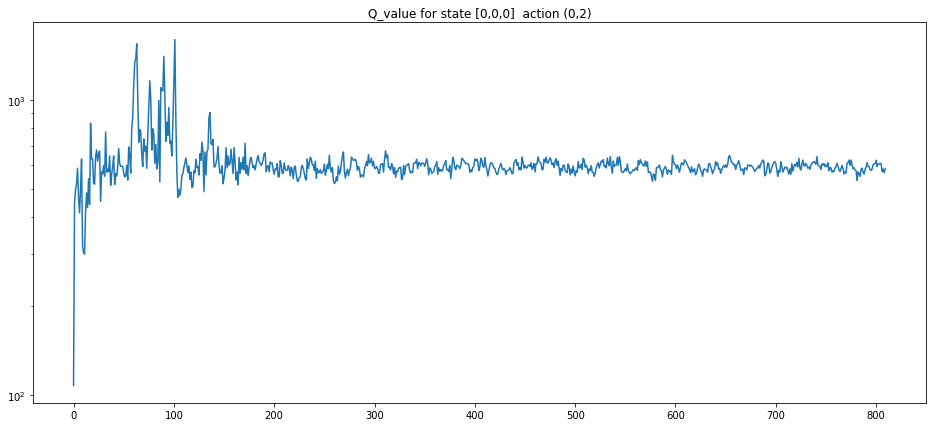

In [32]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [0,0,0]  action (0,2)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [23]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

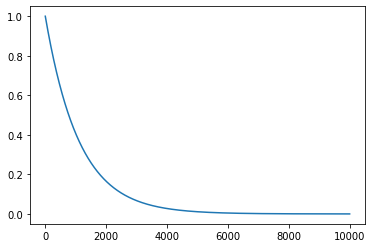

In [24]:
plt.plot(time, epsilon)
plt.show()